In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in adata

In [5]:
# read in post-Milo single-cell adata
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor.h5ad')
adata

AnnData object with n_obs × n_vars = 83477 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'euploid_or_t21', 'donor_type', 'region_finest', 'flushed', 'scrublet_leiden', 'cluster_scrublet_score', 'leiden_scVI_0.1', 'leiden

# Identify significant nhoods

In [9]:
# get significant nhoods
DA_fdr_thresh = 0.1
fcneg_label = 'euploid'
fcpos_label = 'trisomy21'

##############################
nhood_adata = adata.uns['nhood_adata'].copy()
mask_sig = nhood_adata.obs['SpatialFDR'] < DA_fdr_thresh
mask_fcneg = nhood_adata.obs['logFC'] < 0
mask_fcpos = nhood_adata.obs['logFC'] > 0
nhoods_fcneg = list(nhood_adata.obs_names[mask_sig&mask_fcneg])
print(f'FC-negative nhoods: {len(nhoods_fcneg)}')
print(nhoods_fcneg[:5])
nhoods_fcpos = list(nhood_adata.obs_names[mask_sig&mask_fcpos])
print(f'FC-positive nhoods: {len(nhoods_fcpos)}')
print(nhoods_fcpos[:5])

# add to nhood_adata
adata.uns['nhood_adata'].obs['deg_group'] = 'nan'
adata.uns['nhood_adata'].obs.loc[nhoods_fcneg,'deg_group'] = fcneg_label
adata.uns['nhood_adata'].obs.loc[nhoods_fcpos,'deg_group'] = fcpos_label
adata.uns['nhood_adata'].obs['deg_group'].value_counts()

FC-negative nhoods: 238
['nhood58', 'nhood157', 'nhood161', 'nhood178', 'nhood185']
FC-positive nhoods: 339
['nhood2', 'nhood20', 'nhood36', 'nhood53', 'nhood105']


deg_group
nan          6116
trisomy21     339
euploid       238
Name: count, dtype: int64

# Subset cells and nhoods

* Significant nhoods (both FCpos and FCneg nhoods)
* Cells which belong to the significant nhoods

In [13]:
# gent nhood index
mhoods_sel = nhoods_fcneg + nhoods_fcpos
nhood_index = [int(x.replace('nhood','')) for x in mhoods_sel]
nhood_index.sort()

In [29]:
# get cell obsnames
# which belongs to the significant nhoods obtained above
mask = adata.obsm['nhoods'][:,nhood_index].toarray().sum(axis=1)>0 # get cells which has at least one neighbourhod to belong
cell_obsnames = adata.obs_names[mask]
print(len(cell_obsnames))

14846


In [30]:
# subset
## cell
adata_sub = adata[cell_obsnames]
## nhoods, in the two different data storage
adata_sub.obsm['nhoods'] = adata_sub.obsm['nhoods'][:,nhood_index]
print(adata_sub.obsm['nhoods'].shape)
adata_sub.uns['nhood_adata'] = adata_sub.uns['nhood_adata'][nhood_index]
print(adata_sub.uns['nhood_adata'].shape)

(14846, 577)
(577, 24)


# Assess cells which belong to multipe nhoods

In [31]:
mask = adata_sub.obsm['nhoods'].toarray().sum(axis=1)>1 # get cells which has at least two neighbourhod to belong
cells_rep = adata_sub.obs_names[mask]
print(f'number of cells: {adata_sub.shape[0]}')
print(f'fraction of repetitive cells: {len(cells_rep)/adata_sub.shape[0]}')

number of cells: 14846
fraction of repetitive cells: 0.3483766671157214


In [32]:
len(cells_rep)

5172

(14846, 577)


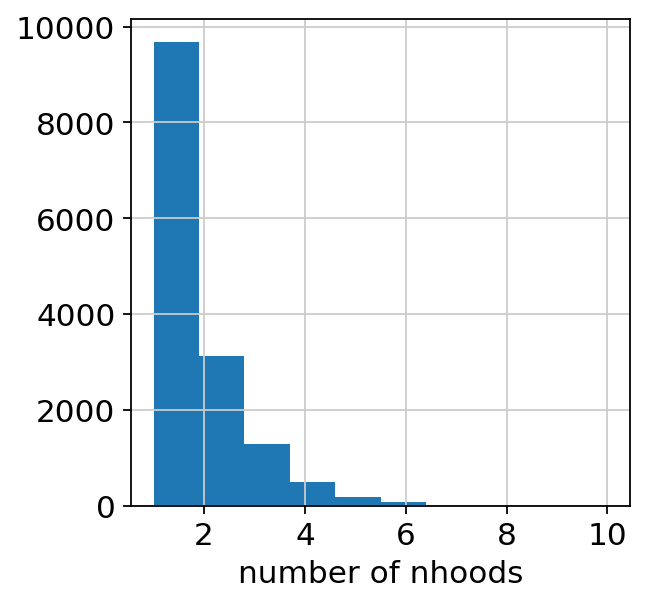

In [34]:
print(adata_sub.obsm['nhoods'].shape)
plt.hist(adata_sub.obsm['nhoods'].toarray().sum(axis=1),bins=10)
plt.xlabel('number of nhoods')
plt.show()

# Re-assign cells to a neighbourhood

* get nhoods which have repetitive cells
* for each nhoods, calculate centroid (based on scVI latent space)
* for each repetitive cell, calculate distance to the centroids of the nhoods, and select the most closest one
* reassigne the repetitive cell only to the closest one

In [35]:
# obtain nhoods which contains repetitive cells
mask = adata_sub[cells_rep].obsm['nhoods'].toarray().sum(axis=0)>0
nhoods_rep = np.nonzero(mask)[0]
print(len(nhoods_rep))
nhoods_rep[:5]

559


array([0, 1, 2, 3, 4])

--> most of the nhoods contain repetitive cells

In [36]:
# get centroid for each nhood
cell_by_nhood = adata_sub.obsm['nhoods'][:,nhoods_rep].copy()
n_cell_per_nhood = cell_by_nhood.toarray().sum(axis=0)
scVI_latent_rep = 'scVI_latent_correcting-donor-region_n-layers-2'
cell_by_scvi = adata_sub.obsm[scVI_latent_rep].copy()
nhood_by_scvi_sum = np.array(np.matmul(cell_by_nhood.T.todense(),cell_by_scvi))
nhood_by_scvi_mean = (nhood_by_scvi_sum.T/n_cell_per_nhood).T # i.e. centroid
nhood_by_scvi_mean = pd.DataFrame(nhood_by_scvi_mean,
                                  index=[f'nhood{str(x)}' for x in nhoods_rep])
print(nhood_by_scvi_mean.shape)
nhood_by_scvi_mean.head()

(559, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
nhood0,0.003166,0.002909,0.000382,-0.001648,1.293855,0.006958,-0.000819,-0.005389,-0.006375,1.023166,...,0.195343,0.001842,1.925441,0.001327,-1.649888,-0.701387,0.000187,0.000751,0.005448,0.193075
nhood1,0.001474,0.007491,-0.000269,0.000323,0.755266,-0.002333,-0.001233,0.011210,0.003308,0.697665,...,-0.434803,-0.000968,-0.823634,0.000014,1.099725,-0.390525,-0.000757,0.005647,-0.000820,0.215920
nhood2,0.001564,0.000401,0.002380,-0.001334,0.653889,0.002361,0.003432,-0.001260,-0.005284,0.816435,...,0.011274,-0.000320,-1.687108,0.001296,-1.190462,0.683065,0.004880,0.002644,0.002137,1.064654
nhood3,0.000624,0.005972,-0.001517,-0.001736,1.038196,-0.003776,-0.004232,0.007270,-0.000215,1.314242,...,-1.436593,-0.002773,-0.515060,-0.001196,0.342509,1.803225,-0.001432,-0.001473,0.001900,0.167200
nhood4,0.001140,-0.000757,0.002992,0.000544,0.829925,0.004271,0.005252,0.003447,-0.000910,1.284316,...,0.421869,-0.001526,-0.703916,0.000122,-0.168653,0.758486,-0.001360,0.002409,-0.000303,0.565516


In [37]:
# for each repetitive cell, calculate distance to the centroids of the nhoods, and select the most closest one
import numpy as np
def assign_cells_to_neighborhoods(cell_nhood, cell_latent, nhood_centroids):
    """
    Assigns each cell to the closest neighborhood (nhood) centroid among the neighborhoods 
    the cell belongs to.
    
    Parameters:
      cell_nhood: 2D binary NumPy array of shape (n_cells, n_nhoods).
                  cell_nhood[i, j] is 1 if cell i belongs to nhood j.
      cell_latent: 2D NumPy array of shape (n_cells, latent_dim) containing the cell coordinates.
      nhood_centroids: 2D NumPy array of shape (n_nhoods, latent_dim) containing the centroids.
    
    Returns:
      A 1D array of length n_cells where each element is the index of the nearest nhood centroid 
      (among those the cell belongs to) for that cell.
      
    Explanation
    1. Distance Computation: The squared Euclidean distance between each cell (vector in latent space) and each nhood centroid is computed using a vectorized approach. This avoids explicit loops and leverages fast linear algebra routines.
    2. Masking: Since each cell only belongs to certain nhoods (as indicated by the cell_nhood binary matrix), we set the distances for non-member nhoods to infinity (np.inf). This ensures that the minimization only considers the valid nhoods.
    3. Choosing the Minimum: Finally, we use np.argmin along the nhood axis (axis=1) to find the index of the closest centroid among those the cell belongs to.  
    """
    # Compute squared Euclidean distances between each cell and each nhood centroid.
    # Using the identity: ||a-b||^2 = ||a||^2 + ||b||^2 - 2 * a.dot(b)
    cell_sq = np.sum(cell_latent**2, axis=1, keepdims=True)   # shape: (n_cells, 1)
    nhood_sq = np.sum(nhood_centroids**2, axis=1)  # shape: (n_nhoods,)
    distances = cell_sq + nhood_sq - 2 * (cell_latent @ nhood_centroids.T)  # shape: (n_cells, n_nhoods)
    
    # Mask distances for nhoods that the cell does not belong to.
    # For these entries, set the distance to a very high value (np.inf) so they are not chosen.
    mask = cell_nhood.astype(bool)
    distances[~mask] = np.inf
    
    # For each cell, find the index of the nhood with the minimal distance.
    closest_nhood = np.argmin(distances, axis=1)
    
    return closest_nhood

In [38]:
%%time
cell_by_nhood = adata_sub[cells_rep].obsm['nhoods'][:,nhoods_rep].toarray().copy()
print(cell_by_nhood.shape)
cell_by_scVI = adata_sub[cells_rep].obsm[scVI_latent_rep].toarray().copy()
print(cell_by_scVI.shape)

assignments = assign_cells_to_neighborhoods(cell_by_nhood, cell_by_scVI, np.array(nhood_by_scvi_mean))
assignments = nhood_by_scvi_mean.index[assignments]
print(len(assignments))
assignments[:5]

(5172, 559)
(5172, 50)
5172
CPU times: user 98.8 ms, sys: 2.6 ms, total: 101 ms
Wall time: 104 ms


Index(['nhood566', 'nhood398', 'nhood395', 'nhood79', 'nhood6'], dtype='object')

In [39]:
# reassign nhoods
cell_index = np.nonzero(adata_sub.obs_names.isin(cells_rep))[0]
nhood_reassigned_index = [int(x.replace('nhood','')) for x in assignments]

cell_by_nhood = adata_sub.obsm['nhoods'].toarray().copy()
cell_by_nhood[cell_index,:] = 0
cell_by_nhood[cell_index,nhood_reassigned_index] = 1
from scipy.sparse import csr_matrix
adata_sub.obsm['nhoods_reassigned'] = csr_matrix(cell_by_nhood)
adata_sub.obsm['nhoods_reassigned']

<14846x577 sparse matrix of type '<class 'numpy.float32'>'
	with 14846 stored elements in Compressed Sparse Row format>

1.0


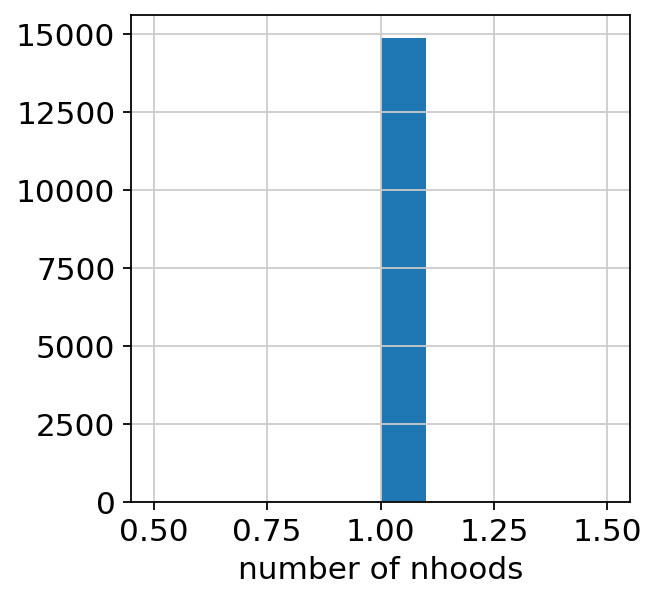

In [41]:
# check
print(np.max(adata_sub.obsm['nhoods_reassigned'].toarray().sum(axis=1)))
plt.hist(adata_sub.obsm['nhoods_reassigned'].toarray().sum(axis=1))
plt.xlabel('number of nhoods')
plt.show()

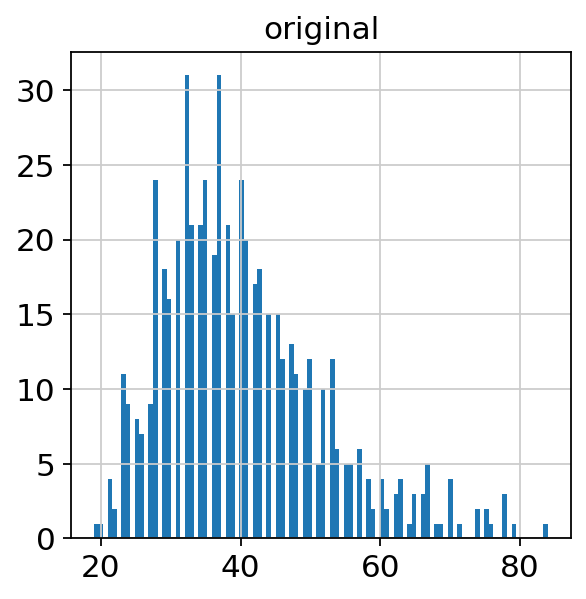

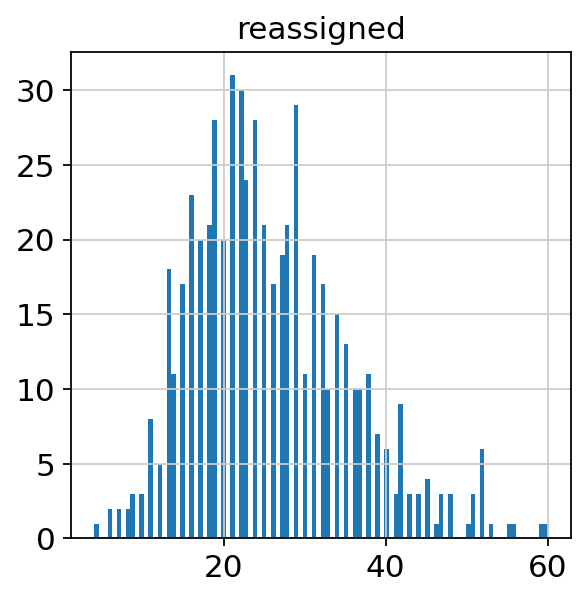

In [42]:
# n_cells per nhood
plt.hist(adata_sub.obsm['nhoods'].toarray().sum(axis=0),bins=100)
plt.title('original')
plt.show()

plt.hist(adata_sub.obsm['nhoods_reassigned'].toarray().sum(axis=0),bins=100)
plt.title('reassigned')
plt.show()

# Save

In [43]:
# save
adata_sub.write('/nfs/team205/heart/anndata_objects/Foetal/trisomy21/Euploid_T21Hearts_Aug2024_sel_subsampled-per-cellstate-donor_cells-in-sig-nhoods-sfdr0p1.h5ad')